# **Customer Review Sentiment Analysis**

In [7]:
import sqlite3
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

In [8]:
# Setting up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
# Connect to your database
conn = sqlite3.connect('products.db')
cursor = conn.cursor()

In [10]:
# Get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Number of tables: {len(tables)}")
print("Tables:", [table[0] for table in tables])


Number of tables: 6
Tables: ['customer', 'product', 'product_details', 'ratings', 'reviews', 'transactions']


In [11]:
# Get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Display each table and its contents
for table in tables:
    table_name = table[0]
    print(f"\n{'='*50}")
    print(f"TABLE: {table_name}")
    print(f"{'='*50}")
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(df)
    print(f"Shape: {df.shape} (rows, columns)\n")


TABLE: customer
                          user_id first_name last_name  age
0    AGIF4RXMGYGGOETIN7H7SHI2HTGA    Gregory   Simpson   53
1    AHPKZL7FJIDA3CLNQ6OMKY46RA7Q     Samuel  Cisneros   32
2    AES7KKTN2JRDCH5T4H3O5HU7XZZQ    Matthew       Lam   16
3    AF4XAUOI5XPGWHCPOTORKBIJSRDA      Tracy     Meyer   36
4    AHN5UNTOQUK2HK26VSI3BYTHO4HQ      Blake   Johnson   82
..                            ...        ...       ...  ...
547  AELIV6UHVC6Z6VA4MIZ464WUHDPA  Elizabeth     Price   14
548  AGLQDDJTHRGIY4KWEXLA3YBD47PQ       Todd      Rice   38
549  AFCF42UEL75CPDL6CLELVNQ4FTTA     Andrew  Galloway   66
550  AG4MIJDYTNWORGOKC2K22CPHFODA     Brooke   Parsons   49
551  AFTLB43X76QKXWYYG4J6KKKGD7QQ      David   Johnson   16

[552 rows x 4 columns]
Shape: (552, 4) (rows, columns)


TABLE: product
      item_id                    item                   category
0          26                  Coffee                  Beverages
1          13               Chocolate                    Coo

# **STEP 1: DATA SELECTION & EXTRACTION**

*  We have 6 tables in our database, but only the 'reviews' table contains customer feedback text that can be analyzed for sentiment
*  We are extracting specific columns (text, title, rating, user_id, parent_asin)  from the reviews table and putting it into a pandas DataFrame
* This separates the relevant data from unnecessary columns and brings it into a format we can easily work with in Python
* We'll also need the product details table to understand which products have positive or negative sentiment

In [12]:
# Extracting reviews data
reviews_df = pd.read_sql_query(
    "SELECT text, title, rating, user_id, parent_asin FROM reviews",
    conn
)

print(f"\nExtracted {len(reviews_df)} rows from reviews table")
print(f"\nDataFrame shape for reviews table: {reviews_df.shape}")
print(f"\nFirst few rows:\n{reviews_df.head()}")


Extracted 4166 rows from reviews table

DataFrame shape for reviews table: (4166, 5)

First few rows:
                                                text  \
0  Excellent!! Yummy!  Great with other foods and...   
1  Excellent!  The best!  I use it with my beef a...   
2  These are very tasty. They are extremely soft ...   
3                                       My favorite!   
4     Great for making brownies and crinkle cookies.   

                                    title  rating  \
0                      Excellent!  Yummy!     5.0   
1                       Delicious!!! Yum!     5.0   
2  Extremely Delicious, but expensive imo     5.0   
3                              Delicious!     5.0   
4                             Great taste     5.0   

                        user_id parent_asin  
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B00CM36GAQ  
1  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B0759B7KLH  
2  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B079TRNVHX  
3  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B07194LN2Z  
4  AFKZENTN

# **STEP 2: HANDLING MISSING VALUES**

* Since, this is real world data, we need to check if any missing or null values exist.
* Some reviews might have empty text or title fields
* If sentiment analysis is being performed on NULL values then the code will not work properly
* After identify these missing values we either:
1. Fill them with empty strings
2. Remove those rows


In [13]:
# Checking for missing values
print("\nMissing values in reviews data:")
print(reviews_df.isnull().sum())

# Check for empty strings
empty_count = (reviews_df['text'] == '').sum()
print(f"Empty reviews: {empty_count}")

# Check for whitespace-only
whitespace_count = (reviews_df['text'].str.strip() == '').sum()
print(f"Whitespace-only: {whitespace_count}")


Missing values in reviews data:
text           0
title          0
rating         0
user_id        0
parent_asin    0
dtype: int64
Empty reviews: 0
Whitespace-only: 1


In [14]:
# Find the row with whitespace-only text
whitespace_rows = reviews_df[reviews_df['text'].str.strip() == '']

print("Whitespace-only reviews found:")
print(whitespace_rows)

Whitespace-only reviews found:
    text                               title  rating  \
368       The best I ever had will buy again     5.0   

                          user_id parent_asin  
368  AHW2LP77UXV3E2T3SIERXOYD7DDA  B079TRNVHX  


Not removing the row as we are computing sentiments using both text and title from review table







# **STEP 3: DATA PREPROCESSING (TEXT CLEANING)**

1. Raw texts contain noise like:
* Special characters (@, #, $, !, ?, etc.) don't carry sentiment
* Mixed case (UPPERCASE, lowercase) can confuse analysis
* Extra whitespace makes text inconsistent
* Punctuation doesn't help sentiment analysis
2. Example: "GREAT!!!! Product!!!" should become "great product"
3. Cleaning ensures consistent, high-quality input for accurate results



We are using both text and title for the analysis using the combined result of the both, so in-case text is not present, we can use title for analysisng with no loss of data

In [15]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace emoticons
    emoticon_dict = {
        r':\)': ' positive ', r':-\)': ' positive ', r':D': ' positive ',
        r':\(': ' negative ', r':-\(': ' negative ', r'T_T': ' negative ',
        r':/': ' skeptical ', r':\|': ' neutral ',
    }
    for emoticon, sentiment in emoticon_dict.items():
        text = re.sub(emoticon, sentiment, text, flags=re.IGNORECASE)

    # Replace emojis
    emoji_dict = {
        '😊': ' positive ', '😍': ' positive ', '❤️': ' positive ', '👍': ' positive ',
        '😢': ' negative ', '😡': ' negative ', '👎': ' negative ',
    }
    for emoji, sentiment in emoji_dict.items():
        text = text.replace(emoji, sentiment)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Strip spaces
    text = text.strip()

    return text

In [16]:
# Applying cleaning to both text and title
reviews_df['cleaned_text'] = reviews_df['text'].apply(clean_text)
reviews_df['cleaned_title'] = reviews_df['title'].apply(clean_text)

# Combining title and text for more comprehensive analysis
reviews_df['combined_text'] = reviews_df['cleaned_title'] + " " + reviews_df['cleaned_text']
# For no repetition, If text is emply then we will use title
reviews_df['combined_text'] = reviews_df['cleaned_text']

print("\n Text preprocessing completed")
print("\nExample of cleaning:")
print(f"Original text:  {reviews_df['text'].iloc[0]}")
print(f"Cleaned text:   {reviews_df['cleaned_text'].iloc[0]}")
print(f"\nOriginal title: {reviews_df['title'].iloc[0]}")
print(f"Cleaned title:  {reviews_df['cleaned_title'].iloc[0]}")
print(f"\nCombined text:  {reviews_df['combined_text'].iloc[0]}")


 Text preprocessing completed

Example of cleaning:
Original text:  Excellent!! Yummy!  Great with other foods and great alone.
Cleaned text:   excellent yummy great with other foods and great alone

Original title: Excellent!  Yummy!
Cleaned title:  excellent yummy

Combined text:  excellent yummy great with other foods and great alone


# **STEP 4: SENTIMENT ANALYSIS**

 Now that we have clean text, we can analyze the sentiment using BERT
- BERT is a deep learning model trained to understand sentiment
- It analyzes text and returns:
  * Label: POSITIVE or NEGATIVE
  * Confidence Score: 0.0 to 1.0 (how confident is BERT?)
- We convert this to a -1 to +1 scale for easier interpretation:
  - Close to -1 = very negative sentiment
  - Close to 0 = neutral sentiment
  - Close to +1 = very positive sentiment
- This allows us to:
  a) Quantify customer sentiment numerically
  b) Classify reviews into sentiment categories
  c) Compare with actual ratings to find inconsistencies

In [17]:
#Importing Bert Module
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

print("Loading BERT model...")

# Load the BERT sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

print("BERT model loaded successfully!")

Loading BERT model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


BERT model loaded successfully!


In [18]:

def get_bert_sentiment(text):
    if not text or len(text.strip()) == 0:
        return 0

    try:
        # BERT works better with shorter texts (max 512 tokens)
        text_truncated = text[:512]

        # Get prediction
        result = sentiment_pipeline(text_truncated)[0]

        # Extracting label and confidence score
        label = result['label']  # 'POSITIVE' or 'NEGATIVE'
        score = result['score']  # 0.0 to 1.0 (confidence)

        # Convert to -1 to 1 scale
        if label == 'POSITIVE':
            return round(score, 3)
        else:
            return round(-score, 3)

    except Exception as e:
        print(f"Error processing text: {e}")
        return 0

print("BERT sentiment function created")

BERT sentiment function created


In [19]:
#testing on sample reviews
print("\n" + "="*80)
print("TESTING BERT ON SAMPLE REVIEWS")
print("="*80)

test_reviews = [
    "This product is amazing! Love it!",
    "Terrible quality, waste of money",
    "It's okay, nothing special",
    "The candy was way too soft and salty",
    "I was never a huge fan until I found this one"
]

print("\nSample predictions:")
for text in test_reviews:
    score = get_bert_sentiment(text)
    category = 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral')
    print(f"\n  Text: \"{text}\"")
    print(f"  Score: {score:.3f} ({category})")


TESTING BERT ON SAMPLE REVIEWS

Sample predictions:

  Text: "This product is amazing! Love it!"
  Score: 1.000 (Positive)

  Text: "Terrible quality, waste of money"
  Score: -1.000 (Negative)

  Text: "It's okay, nothing special"
  Score: -0.808 (Negative)

  Text: "The candy was way too soft and salty"
  Score: -0.997 (Negative)

  Text: "I was never a huge fan until I found this one"
  Score: 0.919 (Positive)


In [20]:
#Applying bert on the all the rows
import time

start_time = time.time()

# Applying BERT to all reviews
reviews_df['bert_sentiment_score'] = reviews_df['combined_text'].apply(get_bert_sentiment)

elapsed_time = time.time() - start_time
print(f"\nBERT analysis completed!")





BERT analysis completed!


In [21]:
#Converting sentiment score to category
def classify_bert_sentiment(score):

    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply classification
reviews_df['bert_sentiment_category'] = reviews_df['bert_sentiment_score'].apply(classify_bert_sentiment)

print("Sentiment classification completed!")
print(f"\nSentiment Score Range: [{reviews_df['bert_sentiment_score'].min():.3f}, {reviews_df['bert_sentiment_score'].max():.3f}]")

Sentiment classification completed!

Sentiment Score Range: [-1.000, 1.000]


In [22]:
#Analysing the sentiment score
sentiment_counts = reviews_df['bert_sentiment_category'].value_counts()
sentiment_percent = reviews_df['bert_sentiment_category'].value_counts(normalize=True) * 100

print("\nAbsolute counts:")
print(sentiment_counts)

print("\nPercentage distribution:")
for category, percent in sentiment_percent.items():
    print(f"  {category:12s}: {percent:6.2f}%")


Absolute counts:
bert_sentiment_category
Positive    2939
Negative    1226
Neutral        1
Name: count, dtype: int64

Percentage distribution:
  Positive    :  70.55%
  Negative    :  29.43%
  Neutral     :   0.02%


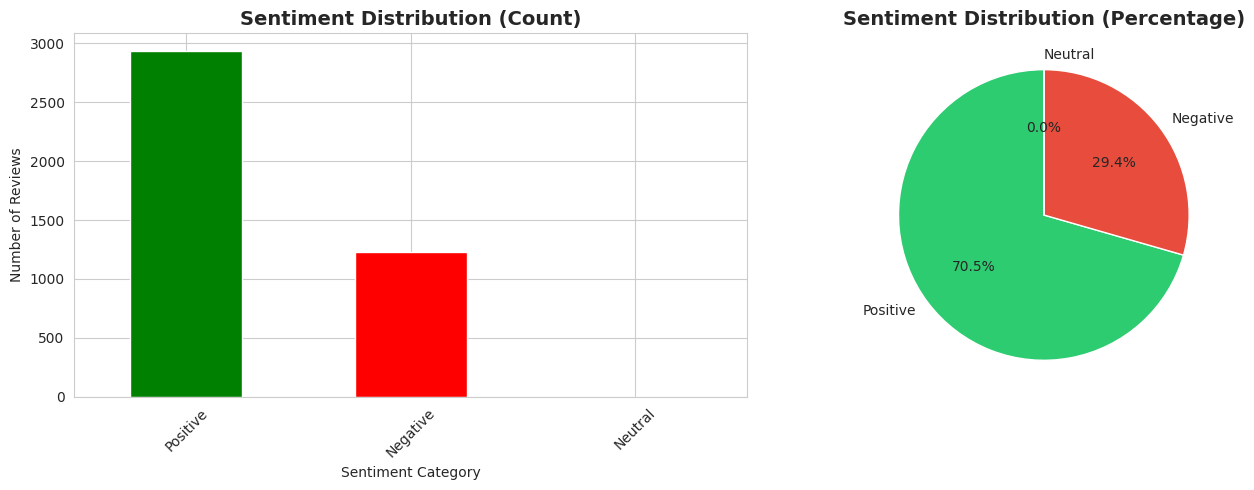


Sentiment distribution visualized!


In [23]:
#Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sentiment_counts.plot(kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
axes[0].set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_xlabel('Sentiment Category')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
sentiment_colors = [colors.get(cat, 'gray') for cat in sentiment_counts.index]
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=sentiment_colors, startangle=90)
axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSentiment distribution visualized!")

Compare Sentiment vs Rating: To know if  5-star reviews have positive sentiment or not.  This reveals whether customers written words match their star ratings

In [24]:
# Creating rating category
reviews_df['rating_category'] = pd.cut(reviews_df['rating'],
                                       bins=[0, 2, 3, 5],
                                       labels=['Low (1-2)', 'Medium (3)', 'High (4-5)'])

# Cross-tabulation
cross_tab = pd.crosstab(reviews_df['rating_category'],
                        reviews_df['bert_sentiment_category'],
                        margins=True)

print("\nCross-tabulation: Star Rating vs BERT Sentiment")
print(cross_tab)


# Calculating average sentiment score by star rating
avg_sentiment_by_rating = reviews_df.groupby('rating')['bert_sentiment_score'].agg(['mean', 'std', 'count'])
print("\n\nAverage BERT Sentiment Score by Star Rating:")
print(avg_sentiment_by_rating)


Cross-tabulation: Star Rating vs BERT Sentiment
bert_sentiment_category  Negative  Neutral  Positive   All
rating_category                                           
Low (1-2)                     455        0        44   499
Medium (3)                    209        0        82   291
High (4-5)                    562        1      2813  3376
All                          1226        1      2939  4166


Average BERT Sentiment Score by Star Rating:
            mean       std  count
rating                           
1.0    -0.865770  0.471545    344
2.0    -0.721948  0.668663    155
3.0    -0.431237  0.871944    291
4.0     0.367932  0.902085    470
5.0     0.715876  0.670391   2906


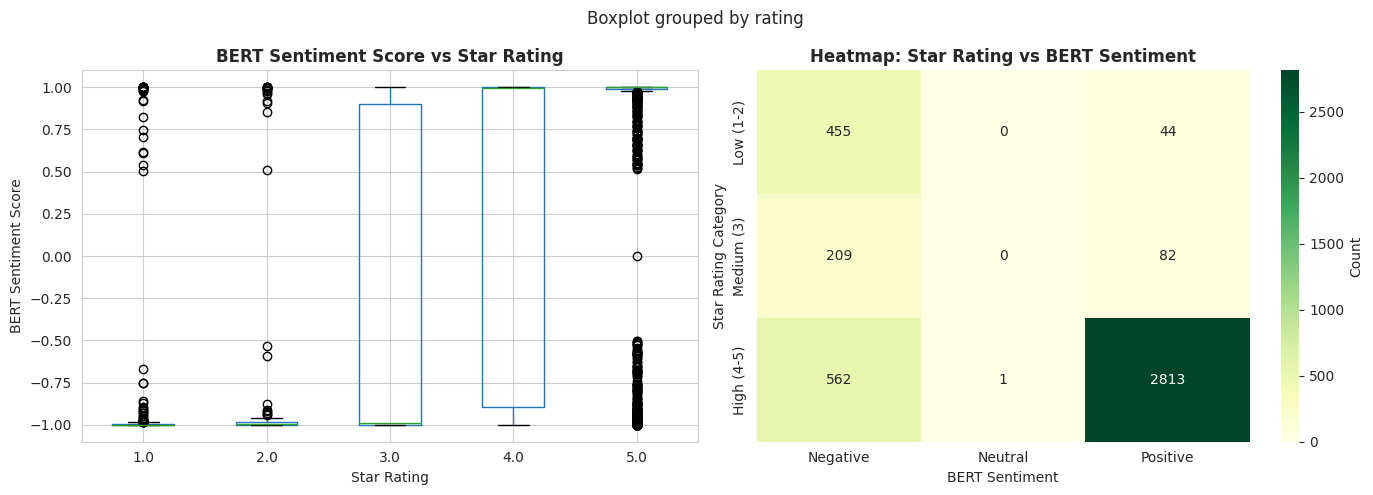


Rating vs Sentiment comparison completed!


In [25]:
#Visualisation
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
reviews_df.boxplot(column='bert_sentiment_score', by='rating', ax=axes[0])
axes[0].set_title('BERT Sentiment Score vs Star Rating', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('BERT Sentiment Score')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Heatmap of cross-tab (excluding margins)
cross_tab_no_margins = pd.crosstab(reviews_df['rating_category'],
                                   reviews_df['bert_sentiment_category'])
sns.heatmap(cross_tab_no_margins, annot=True, fmt='d', cmap='YlGn', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Heatmap: Star Rating vs BERT Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('BERT Sentiment')
axes[1].set_ylabel('Star Rating Category')

plt.tight_layout()
plt.show()

print("\nRating vs Sentiment comparison completed!")

# **STEP 5: ANALYZE SENTIMENT BY PRODUCT (parent_asin)**

We now have sentiment scores for each review, but we don't know which products
  they're about
- We need to join the reviews table with the product table
- This allows us to answer business questions like:
  * Which products have the most positive/negative sentiment?
  * Which product categories get the best reviews?
  * Are there products where sentiment doesn't match the rating?
- We use parent_asin (product identifier) as the joining key

In [26]:
# Group by product
product_sentiment = reviews_df.groupby('parent_asin').agg({
    'bert_sentiment_score': ['mean', 'std', 'min', 'max', 'count'],
    'rating': 'mean',
    'bert_sentiment_category': lambda x: (x == 'Positive').sum()
}).round(3)
product_sentiment.columns = ['avg_sentiment', 'std_sentiment', 'min_sentiment',
                            'max_sentiment', 'review_count', 'avg_rating', 'positive_count']

# Sort by average sentiment
product_sentiment = product_sentiment.sort_values('avg_sentiment', ascending=False)

print("\nTop 10 Products by BERT Sentiment Score:")
print(product_sentiment.head(10))

print("\n\nBottom 10 Products by BERT Sentiment Score:")
print(product_sentiment.tail(10))


Top 10 Products by BERT Sentiment Score:
             avg_sentiment  std_sentiment  min_sentiment  max_sentiment  \
parent_asin                                                               
B0004LXWA0             1.0            NaN            1.0            1.0   
B0CGCVNTHR             1.0            NaN            1.0            1.0   
B0008JEYLY             1.0            NaN            1.0            1.0   
B00099XO5U             1.0            NaN            1.0            1.0   
B0000E2YFL             1.0            NaN            1.0            1.0   
B0000EIEIU             1.0            NaN            1.0            1.0   
B0000VM8R2             1.0            NaN            1.0            1.0   
B07CZVBMNW             1.0            NaN            1.0            1.0   
B07D1FPKPS             1.0            NaN            1.0            1.0   
B07D1YW9XZ             1.0            NaN            1.0            1.0   

             review_count  avg_rating  positive_count  
p

In [27]:
# Map parent_asin to item_id
asin_to_item = pd.read_sql_query(
    "SELECT DISTINCT parent_asin, item_id FROM ratings",
    conn
)

# Add to your product_sentiment
product_sentiment_with_item = product_sentiment.reset_index().merge(
    asin_to_item,
    on='parent_asin',
    how='left'
)

# Get product table for category
product_table = pd.read_sql_query(
    "SELECT item_id, category FROM product",
    conn
)

# Add category
product_sentiment_with_category = product_sentiment_with_item.merge(
    product_table,
    on='item_id',
    how='left'
)

# Filter minimum reviews (to avoid single-review bias)
MIN_REVIEWS = 5
filtered = product_sentiment_with_category[
    product_sentiment_with_category['review_count'] >= MIN_REVIEWS
].copy()

print(f"\nFiltered to products with {MIN_REVIEWS}+ reviews: {len(filtered)}")

# Get top 3 per category
top_3_recommendations = (filtered
    .sort_values(['category', 'avg_sentiment'], ascending=[True, False])
    .groupby('category')
    .head(3)
    .reset_index(drop=True)
)

print(f"\nTop 3 per category: {len(top_3_recommendations)} products")


Filtered to products with 5+ reviews: 17

Top 3 per category: 0 products


In [28]:
# Add product details (brand, title from product_details)
product_details_table = pd.read_sql_query(
    "SELECT item_id, brand, title FROM product_details",
    conn
)

# Add product info (item name from product table)
product_info = pd.read_sql_query(
    "SELECT item_id, item FROM product",
    conn
)

# Merge details
final_recommendations = top_3_recommendations.merge(
    product_details_table,
    on='item_id',
    how='left'
).merge(
    product_info,
    on='item_id',
    how='left'
)

Fetching the Top three rated items in each category


In [29]:
# Loading ratings (this is our base - it has item_id → category link)
ratings_df = pd.read_sql_query("SELECT * FROM ratings", conn)
print(f"  Ratings: {len(ratings_df)} rows")

# Loading product table for category
product_df = pd.read_sql_query("SELECT item_id, category, item FROM product", conn)
print(f"  Products: {len(product_df)} rows")

# Loading sentiment scores (grouped by parent_asin)
print(f"  Sentiment: {len(product_sentiment)} rows (from your notebook)")


  Ratings: 1604 rows
  Products: 1604 rows
  Sentiment: 3131 rows (from your notebook)


In [30]:
# ============================================================================
# step 1: Loading data
# ============================================================================

print("\nStep 1: Load ratings data")

ratings_df = pd.read_sql_query("SELECT * FROM ratings", conn)
product_df = pd.read_sql_query("SELECT item_id, category, item FROM product", conn)
product_details = pd.read_sql_query("SELECT item_id, title, price FROM product_details", conn)

# Get your sentiment scores

sentiment_reset = product_sentiment.reset_index()

print(f"  Ratings: {len(ratings_df)}")
print(f"  Sentiment: {len(sentiment_reset)}")

# ============================================================================
# STEP 2: Merging everything together
# ============================================================================
print("\nMerging ratings + sentiment + product info")

# Merging ratings with sentiment
df_merged = ratings_df.merge(
    sentiment_reset,
    on='parent_asin',
    how='left'
)

# Adding category
df_with_category = df_merged.merge(
    product_df,
    on='item_id',
    how='left'
)

# Adding product details
df_complete = df_with_category.merge(
    product_details,
    on='item_id',
    how='left'
)

print(f" Combined data: {len(df_complete)}")

# ============================================================================
# STEP 3: Filtering for products with sentiment + category
# ============================================================================

print("\nFiltering for products with sentiment data")

df_filtered = df_complete[
    (df_complete['avg_sentiment'].notna()) &
    (df_complete['category'].notna())
].copy()

print(f"  Products with sentiment: {len(df_filtered)}")

# ============================================================================
# STEP 4: Getting top 3 per ITEM
# ============================================================================

print("\nGetting top 3 per ITEM by sentiment")

top_3_final = (df_filtered
    .sort_values(['item', 'avg_sentiment'], ascending=[True, False])
    .groupby('item')
    .head(3)
    .reset_index(drop=True)
)

print(f"  Top 3 total: {len(top_3_final)}")
print(f"  Items: {top_3_final['item'].nunique()}")



# ============================================================================
# STEP 5: Selecting columns for Tableau (NO BRAND)
# ============================================================================

print("\nSelect final columns for Tableau")

# Select only the columns we need
export_cols = [
    'item_id',
    'item',
    'category',
    'title',
    'price',
    'parent_asin',
    'avg_sentiment',
    'review_count',
    'average_rating'
]

final_export = top_3_final[export_cols].copy()

# Add rank within ITEM
final_export['rank'] = final_export.groupby('item').cumcount() + 1

# Reorder columns
final_export = final_export[[
    'rank',
    'category',
    'item',
    'title',
    'price',
    'avg_sentiment',
    'review_count',
    'average_rating',
    'item_id',
    'parent_asin'
]]

# ============================================================================
# STEP 6: Displaying final table
# ============================================================================

print("\n" + "="*80)
print("FINAL TABLE FOR TABLEAU")
print("="*80)

print(f"\nTotal rows: {len(final_export)}")
print(f"Total categories: {final_export['category'].nunique()}")

print("\n" + final_export.to_string(index=False))

# ============================================================================
# DISPLAY BY CATEGORY (3 products per category)
# ============================================================================

print("\n" + "="*80)
print("GROUPED BY CATEGORY (Top 3 per category)")
print("="*80)

for item_name in sorted(final_export['item'].unique()):
    item_data = final_export[final_export['item'] == item_name]
    print(f"\n📦 {item_name.upper()}")
    print(f"   {'-' * 130}")

    for _, row in item_data.iterrows():
        print(f"\n   Rank #{int(row['rank'])} - {row['title']}")
        print(f"      Category: {row['category']}")
        print(f"      Price: ${row['price']}")
        print(f"      ⭐ Sentiment: {row['avg_sentiment']:.3f} (from {int(row['review_count'])} reviews)")
        print(f"      📊 Star Rating: {row['average_rating']:.1f}")
        print(f"      ASIN: {row['parent_asin']}")



Step 1: Load ratings data
  Ratings: 1604
  Sentiment: 3131

Merging ratings + sentiment + product info
 Combined data: 33234722

Filtering for products with sentiment data
  Products with sentiment: 546182

Getting top 3 per ITEM by sentiment
  Top 3 total: 279
  Items: 93

Select final columns for Tableau

FINAL TABLE FOR TABLEAU

Total rows: 279
Total categories: 45

 rank                               category                                         item                                                                                                                                                                                                  title  price  avg_sentiment  review_count  average_rating  item_id parent_asin
    1                     Nut & Seed Butters                                Almond Butter                                                                                                                                 Hershey's Reese's Crunchy Cookie Peanut butter

Exporting the top rated products in final database

In [31]:
print("\nConnecting to product_apriori.db")

tableau_db = sqlite3.connect('product_apriori.db')
tableau_cursor = tableau_db.cursor()

print(" Connected to product_apriori.db")


Connecting to product_apriori.db
 Connected to product_apriori.db


In [32]:
print("\n Creating table structure")

create_table_sql = """
CREATE TABLE IF NOT EXISTS top_products (
    rank INTEGER,
    category TEXT,
    item TEXT,
    title TEXT,
    price REAL,
    avg_sentiment REAL,
    review_count REAL,
    average_rating REAL,
    item_id INTEGER,
    parent_asin TEXT,
    PRIMARY KEY (rank, item, parent_asin)
)
"""

tableau_cursor.execute(create_table_sql)
tableau_db.commit()

print("Table 'top_products' created in product_apriori.db")


 Creating table structure
Table 'top_products' created in product_apriori.db


In [33]:
#Inserting final_export DataFrame into database

print("\nInserting data into top_products table")

try:
    final_export.to_sql('top_products', tableau_db, if_exists='replace', index=False)
    print(f"Successfully inserted {len(final_export)} rows into top_products table")
except Exception as e:
    print(f"Error inserting data: {e}")


Inserting data into top_products table
Successfully inserted 279 rows into top_products table


In [34]:
# Verify the data


print("\Verifying data in product_apriori.db")

verification_query = """
SELECT
    COUNT(*) as total_rows,
    COUNT(DISTINCT item) as unique_items,
    COUNT(DISTINCT category) as unique_categories,
    MIN(avg_sentiment) as min_sentiment,
    MAX(avg_sentiment) as max_sentiment,
    AVG(average_rating) as avg_star_rating
FROM top_products
"""

result = pd.read_sql_query(verification_query, tableau_db)
print("\nDatabase Summary:")
print(result.to_string(index=False))

\Verifying data in product_apriori.db

Database Summary:
 total_rows  unique_items  unique_categories  min_sentiment  max_sentiment  avg_star_rating
        279            93                 45         -0.998            1.0         4.488172


In [35]:
# Displaying the sample data

print("\n\nSample Data from product_apriori.db:")

sample_query = """
SELECT rank, item, title, avg_sentiment, average_rating
FROM top_products
WHERE item IN ('Coffee', 'Cereal', 'Candy Bars')
ORDER BY item, rank
LIMIT 9
"""

sample = pd.read_sql_query(sample_query, tableau_db)
print(sample.to_string(index=False))




Sample Data from product_apriori.db:
 rank       item                                                                                                                                                                              title  avg_sentiment  average_rating
    1 Candy Bars                                                                                                          Cherry Sours Chewy Candy Balls - 3 lbs of Tart Fresh Delicious Bulk Candy            1.0             4.3
    2 Candy Bars                                                                                                       Haribo Halloween Sweet or Scary Mix, 11.85 oz Bag Aprox.22 count(Pack of 12)            1.0             4.3
    3 Candy Bars                                                                                               Filled Raspberries - 1.5 lbs of Individually Sweet Raspberry Wrapped Bulk Hard Candy            1.0             4.3
    1     Cereal                                     

In [36]:
#ListING all tables in product_apriori.db

print("\n All tables in product_apriori.db")

tables_query = """
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name
"""

tables = pd.read_sql_query(tables_query, tableau_db)
print(tables.to_string(index=False))


 All tables in product_apriori.db
           name
       customer
  market_basket
        product
product_details
        ratings
        reviews
   top_products
   transactions


In [37]:
tableau_db.close()
print("\nConnection closed successfully")


Connection closed successfully
